#### Titanic survival prediction
- The goal is to find and train the best model to accuracy predict survival rate of any passenger on board. 
- Dataset can be found [here](https://www.kaggle.com/competitions/titanic).

In [3]:
# data analysis and wrangling
import numpy as np
import pandas as pd
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# SKlearn preprocessing, pipelines 
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Classifier models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
 
# Hyperparameter tuning and model evaluation
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

### Step 1: Preprocessing
- Handle missing values.
- Drop unrelated datatypes.
- Handle transform values into cateogrical and numerical. 

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
 
print('Number of rows (Train): ' + str(train.shape[0]))
print('Number of duplicate rows (Train): ' + str(train.duplicated().sum()))
print('_' * 40)
print('Number of rows (Test): ' + str(test.shape[0]))
print('Number of duplicate rows (Test): ' + str(test.duplicated().sum()))
train[:5].head()

Number of rows (Train): 891
Number of duplicate rows (Train): 0
________________________________________
Number of rows (Test): 418
Number of duplicate rows (Test): 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Check data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- We got int, float and object (string)

In [6]:
# Check for unqiue values
for col in train.columns: 
    print(f"{col} : {train[col].nunique()} unique values")

print('_'*70)

# Check for any null values
print(f"\nNull values (train):\n{train.isnull().sum()} ")

print('_'*70)

# Check for any outliers and count
print(f"\n{train.describe()}")

print('_'*70)

print(f"\n{train.describe(include="O")}")



PassengerId : 891 unique values
Survived : 2 unique values
Pclass : 3 unique values
Name : 891 unique values
Sex : 2 unique values
Age : 88 unique values
SibSp : 7 unique values
Parch : 7 unique values
Ticket : 681 unique values
Fare : 248 unique values
Cabin : 147 unique values
Embarked : 3 unique values
______________________________________________________________________

Null values (train):
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 
______________________________________________________________________

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min   

- We got missing values for both train and test dataset which are age and cabin.
- We got outliers: Age, SibSp, Parch and Fare. 
    - Their difference between the 75% and 100% is too high compared to lower quantile. 

In [7]:
# Drop Irrellevant features
train.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1, inplace=True)
test.drop(['Cabin', 'Ticket'], axis=1, inplace=True) # do not drop PassengerId as we will need it for test submission

In [8]:
# Extract and create Title column from name 
for df in [train, test]: # look for all characters of A-Z / a-z
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [9]:
# Group different titles to more common names 
# "Miss", "Lady", and "Col" may have higher survival rates because of their social standing.
common = ['Master', 'Mr', 'Miss', 'Mrs']
for df in [train,test]: 
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = [x if x in common else 'Rare' for x in df['Title']]

train['Title'].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

In [10]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [11]:
# Handle missing values and transform

# Define categorical or numerical the datatype of features
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title']
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']

# Do imputation and transform
categorical_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transform = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

# Exectute
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transform, categorical_features),
        ('num', numerical_transform, numerical_features)
    ]
)

# Model Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

In [12]:
X = train.drop('Survived', axis=1)
y = train['Survived']
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [13]:
X_transformed = preprocessor.fit_transform(X)
X_transformed

array([[ 0.        ,  0.        ,  1.        , ...,  1.        ,
         0.        , -0.3120106 ],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  2.46124229],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        , -0.28277666],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  1.        ,
         2.        ,  0.38960398],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.67328148],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        , -0.29035583]], shape=(891, 17))

In [14]:
# feature names
feature_names = preprocessor.get_feature_names_out()
splitter = [feature.split('__')[1] for feature in feature_names]
X_transformed_df = pd.DataFrame(X_transformed, columns=splitter)
X_transformed_df.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Age,SibSp,Parch,Fare
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.480000,1.0,0.0,-0.312011
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.586667,1.0,0.0,2.461242
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.213333,0.0,0.0,-0.282777
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.386667,1.0,0.0,1.673732
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.386667,0.0,0.0,-0.277363


In [15]:
X_transformed_df.isna().sum()

Pclass_1        0
Pclass_2        0
Pclass_3        0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rare      0
Age             0
SibSp           0
Parch           0
Fare            0
dtype: int64

### Step 2: Exploratory Data Analysis (EDA)
- Check for any outliers

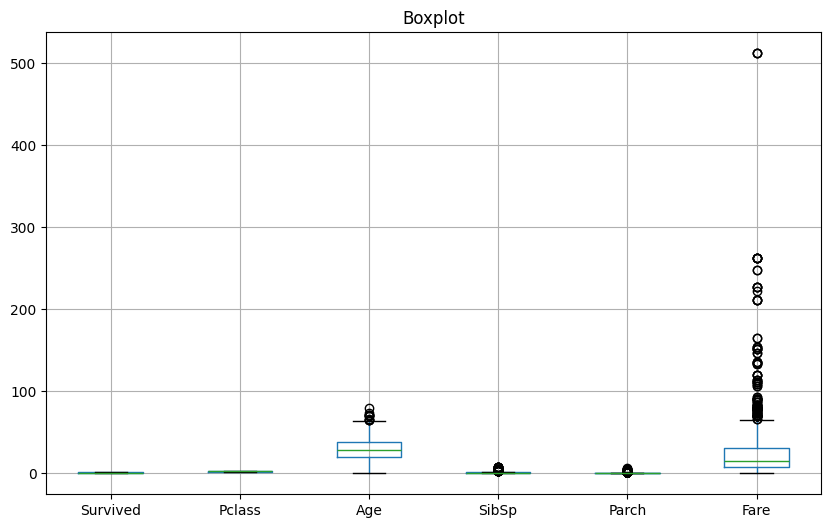

In [16]:
# Before processing
numeric_features = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
train[numeric_features].boxplot(figsize=(10,6))
plt.title("Boxplot")
plt.show()

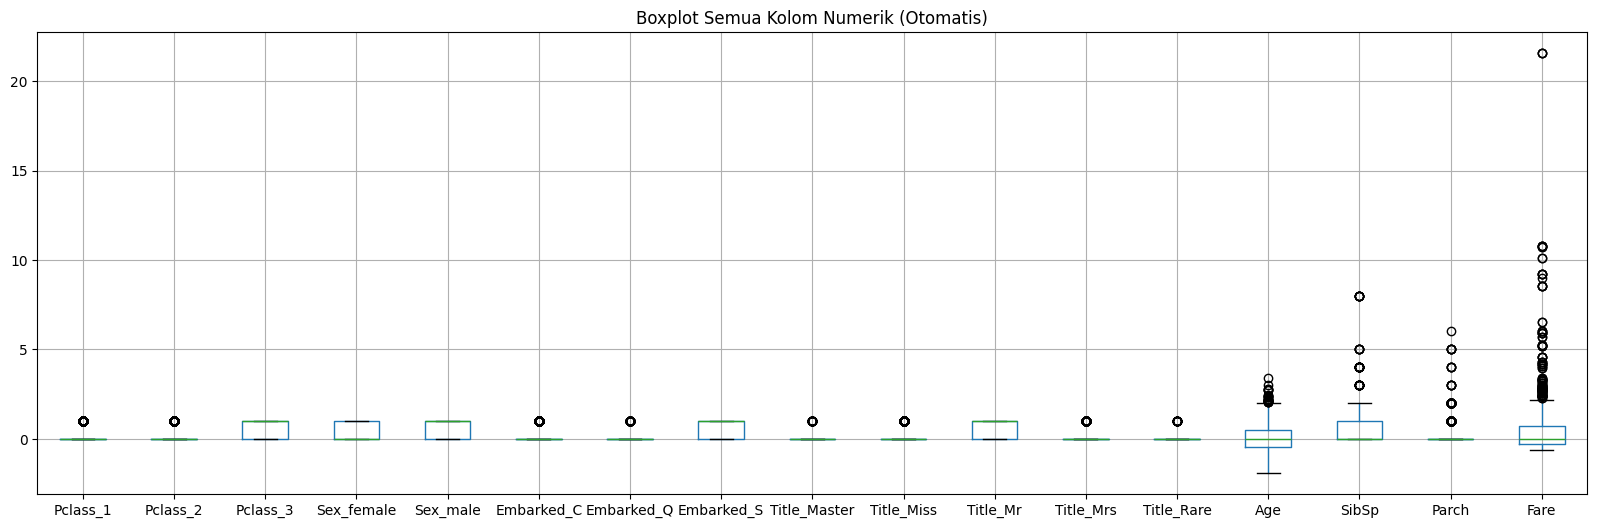

In [17]:
# After processing
numerical_features =  X_transformed_df.select_dtypes(include=['int64', 'float64']).columns
X_transformed_df[numerical_features].boxplot(figsize=(20,6))
plt.title("Boxplot Semua Kolom Numerik (Otomatis)")
plt.show()

- Boxplot shows right-skew and extreme outlier for Fare. 
- Age contains moderate outliers at higher values but remains largely concentrated within a typical adult range (below 100).  
- SibSp and Parch are discrete count variables with a few high-value outliers, reflecting uncommon large family groups rather than noise. 
- Survived and Pclass are categorical encodings, so outlier interpretation is not meaningful for them.

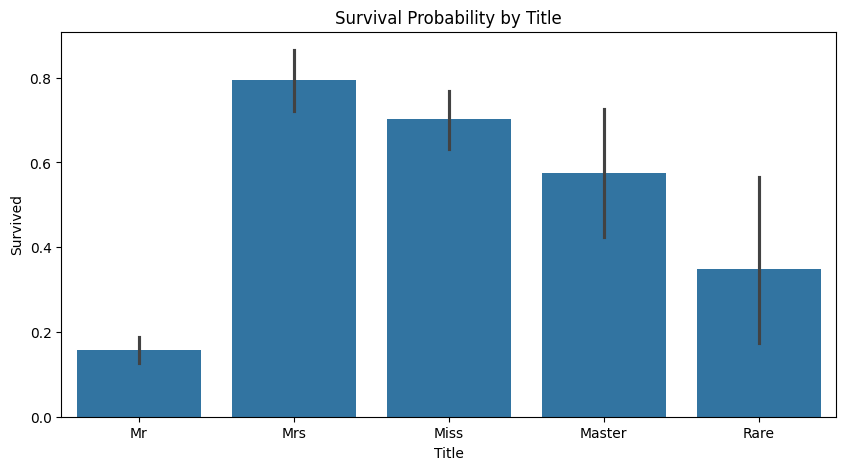

In [18]:
# Survival rate by Title
plt.figure(figsize=(10, 5))
sns.barplot(x='Title', y='Survived', data=train)
plt.title('Survival Probability by Title')
plt.show()

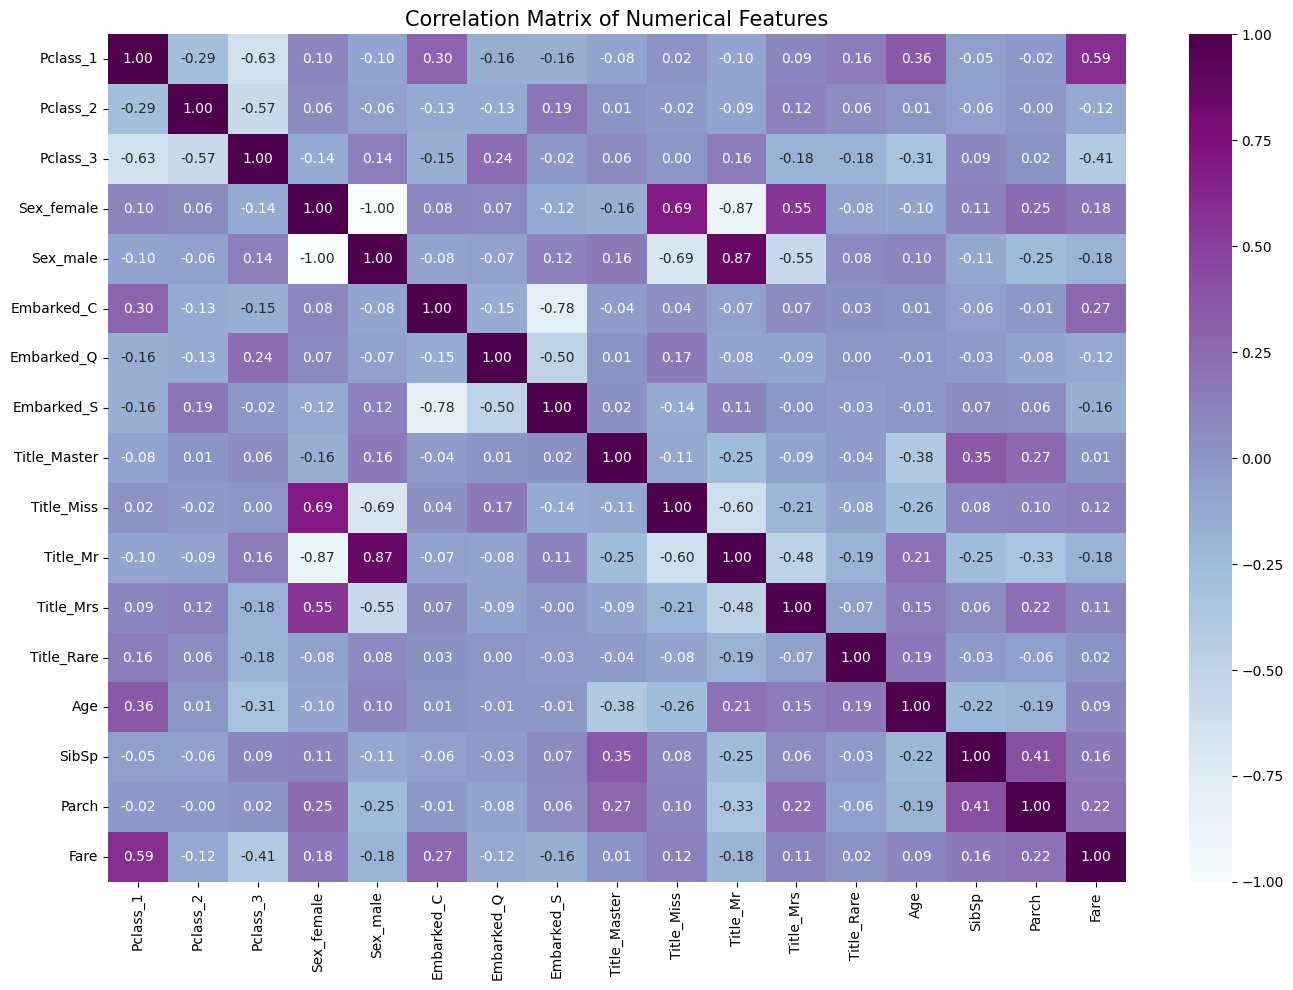

In [19]:
# Check corrleation:
corr = X_transformed_df.corr()
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="BuPu")
ax.set_title("Correlation Matrix of Numerical Features", fontsize=15)
plt.tight_layout()
plt.show()

### Step 3: Train model

In [20]:
# dictionary model
models = {'Logistic Regression': LogisticRegression(max_iter=1000),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'GBM': GradientBoostingClassifier(),
        'LightGBM': LGBMClassifier(verbose = -1),
        'Catboost': CatBoostClassifier(verbose = 0),
        'Histogram-based Gradient Boosting Classification Tree': HistGradientBoostingClassifier()
        }

def fit_and_find_best_model(ml, train_X, test_X, train_y, test_y):
    np.random.seed(42)
    model_scores = {}
    for name, model in ml.items():
        model.fit(train_X, train_y)
        y_pred = model.predict(test_X)
        model_scores[name] = round(metrics.accuracy_score(test_y, y_pred) * 100, 2)
    return model_scores

In [21]:
# Split x and y
np.random.seed(42)
X = train.drop('Survived', axis=1)
y = train['Survived']

X_transformed = preprocessor.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2)

In [22]:
model_score = fit_and_find_best_model(ml=models,
                           train_X=X_train,
                           test_X=X_test,
                           train_y=y_train,
                           test_y=y_test)
model_compare = (pd.DataFrame(model_score, index=['Accuracy']).T).sort_values(by='Accuracy', ascending=False)
model_compare

c:\Workflow\Python interpreter\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy
Histogram-based Gradient Boosting Classification Tree,85.47
GBM,82.68
K-Nearest Neighbors,82.68
Random Forest,82.68
Catboost,82.12
Logistic Regression,81.56
XGBoost,81.56
LightGBM,81.56
Decision Tree,77.09


- Top 4 best models:
    - Histogram-based Gradient Boosting Classification Tree.
    - GBM.
    - K-Nearest Neighbors.
    - Random Forest.

#### Step 4: Model tunning 

- Check baseline performance. 

- Optimization: Use `RandomizedSearchCV` & `GridSearch` to find the best settings.

- Validation: Use `cross_val_score` to confirm the baseline.

In [23]:
# Check model baseline performance
HGBC_base = cross_val_score(HistGradientBoostingClassifier(), X_train, y_train, cv=5)
print(f"HistGrad Boost Classifier CV Mean: {HGBC_base.mean() * 100:.2f}%")

GBM_base = cross_val_score(GradientBoostingClassifier(), X_train, y_train, cv=5)
print(f"GBM CV Mean: {GBM_base.mean() * 100:.2f}%")

KNN_base = cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=5)
print(f"KNN CV Mean: {KNN_base.mean() * 100:.2f}%")

RF_base = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=5)
print(f"Random Forest CV Mean: {RF_base.mean() * 100:.2f}%")

HistGrad Boost Classifier CV Mean: 81.88%
GBM CV Mean: 81.88%
KNN CV Mean: 80.62%
Random Forest CV Mean: 80.76%


In [24]:
# Optimization:
 
# Define the models and their parameter grids
model_tuning_configs = [
    {
        'name': 'HistGradientBoosting',
        'model': HistGradientBoostingClassifier(random_state=42),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_iter': [100, 200, 300],
            'max_depth': [3, 5, 10, None],
            'l2_regularization': [0, 0.1, 1.0]
        }
    },
    {
        'name': 'GBM',
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 8]
        }
    },
    {
        'name': 'RandomForest',
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'max_features': ['sqrt', 'log2']
        }
    },
    {
        'name': 'KNN',
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'leaf_size': [20, 30, 40]
        }
    }
]

# Run RandomizedSearch for each
rs_best_models = {}

for config in model_tuning_configs:
    rs = RandomizedSearchCV(
        config['model'],
        param_distributions=config['params'],
        n_iter=15, # Try 15 random combinations for each
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    rs.fit(X_train, y_train)
    rs_best_models[config['name']] = {
        'best_score': rs.best_score_,
        'best_params': rs.best_params_,
        'best_estimator': rs.best_estimator_
    }

# Compare the results
for name, results in rs_best_models.items():
    print(f"{name}: Best CV Score = {results['best_score']:.4f}")


HistGradientBoosting: Best CV Score = 0.8230
GBM: Best CV Score = 0.8244
RandomForest: Best CV Score = 0.8328
KNN: Best CV Score = 0.8202


- Best model: Random Forest with CV score of 83.28%

In [25]:
# GridSearchCV
gs_best_models = {}

# Initialize GridSearchCV
for config in model_tuning_configs:
    print(f"--- Grid Searching {config['name']} ---")
    gs = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        n_jobs=-1,
        verbose=1,
        scoring='accuracy'
    )

    # Fit it
    gs.fit(X_train, y_train)
    gs_best_models[config['name']] = {
        'best_score': gs.best_score_,
        'best_params': gs.best_params_,
        'best_estimator': gs.best_estimator_
    }

# Compare the results
for name, results in gs_best_models.items():
    print(f"{name}: Best CV Score = {results['best_score']:.4f}")

 

--- Grid Searching HistGradientBoosting ---
Fitting 5 folds for each of 144 candidates, totalling 720 fits
--- Grid Searching GBM ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
--- Grid Searching RandomForest ---
Fitting 5 folds for each of 72 candidates, totalling 360 fits
--- Grid Searching KNN ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
HistGradientBoosting: Best CV Score = 0.8300
GBM: Best CV Score = 0.8244
RandomForest: Best CV Score = 0.8328
KNN: Best CV Score = 0.8202


### Step 4: Model Evaluation

In [26]:
# Get the highest CV score (Random Forest)
best_model = gs_best_models['RandomForest']['best_estimator']

# Make predictions
y_preds = best_model.predict(X_test)

# Show the Classification Report
print("-------- Random Forest Evaluation --------")
print(classification_report(y_test, y_preds))
 
plt.show()

-------- Random Forest Evaluation --------
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       105
           1       0.82      0.74      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



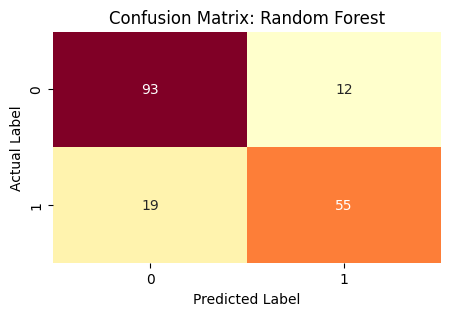

In [27]:
# Plot Matrix graph
def plot_conf_mat(y_test, y_preds):
    # Calculate the actual confusion matrix
    conf_mat = confusion_matrix(y_test, y_preds)
    
    # Plot matrix
    fig, ax = plt.subplots(figsize=(5, 3))
    ax = sns.heatmap(conf_mat,
                     annot=True,     # Show the numbers
                     fmt='d',        # Format as integers 
                     cbar=False, 
                     cmap='YlOrRd')  # A nice color map
    
    plt.xlabel('Predicted Label') # Swapped to match standard layout
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix: Random Forest')
    plt.show()

# Plot
plot_conf_mat(y_test, y_preds)

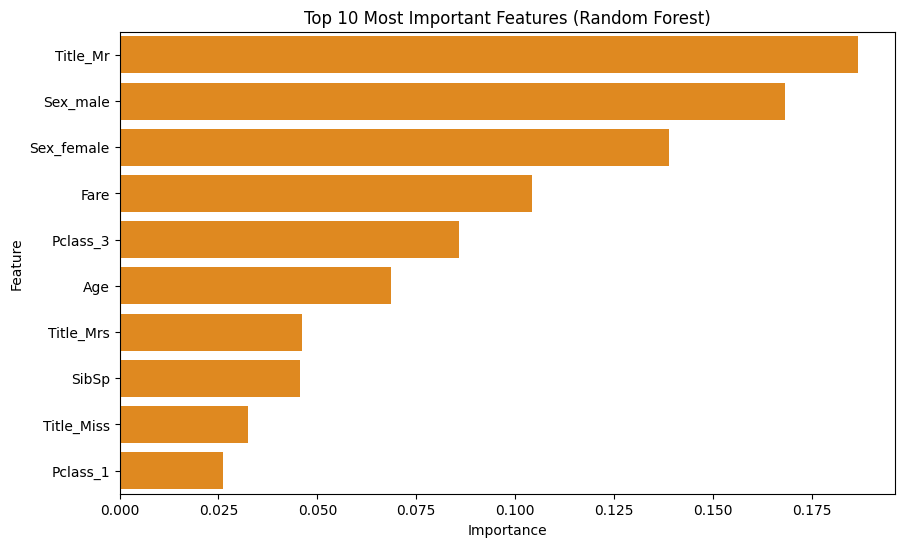

In [28]:
# Get feature names from your earlier 'splitter' code
importances = best_model.feature_importances_
feat_importance_df = pd.DataFrame({'Feature': splitter, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(10),color='darkorange')
plt.title("Top 10 Most Important Features (Random Forest)")
plt.show()

- It seems male are more likely to survive than female. 

In [29]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,Mrs


In [ ]:
# Make sure test df shape is same as train df 
passenger_ids = test['PassengerId']
X_test_final_raw = test.drop(['PassengerId', 'Name'], axis=1)

# Transform
X_test_final = preprocessor.transform(X_test_final_raw)

# Predict using your best GridSearch model
predictions = best_model.predict(X_test_final)

# Create the submission file
output = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': predictions
})

output.to_csv('Titanic-submission.csv', index=False)